In [1]:
# import and dataset loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from kneed import KneeLocator
from yellowbrick.cluster import SilhouetteVisualizer

dataset = pd.read_csv("example_dataset.csv")


In [2]:
#fasttext embedding
import fasttext
train_data_path = "bigrams.txt"
dim = 3
model = fasttext.train_unsupervised(train_data_path, model="skipgram", dim=3, epoch=20)
words = model.get_words()
dict_skipgram = {w: model.get_word_vector(w) for w in words}
domain_names = dataset["bigrams"].to_numpy()
max_len = np.max([len(x.split()) for x in domain_names])
embedded_domain_names = []
for name in domain_names:
    sequences = np.array(
        [dict_skipgram.get(token) if dict_skipgram.get(token) is not None else np.zeros(dim)
         for token in name.split()], dtype=np.single)
    pad = np.zeros(dim * (max_len - len(name.split())), dtype=np.single)
    embedded_domain_name = np.concatenate((sequences, pad), axis=None, dtype=np.single)
    embedded_domain_names.append(embedded_domain_name)
embedded_domain_names_df = pd.DataFrame(embedded_domain_names)

Read 0M words
Number of words:  1330
Number of labels: 0
Progress: 100.0% words/sec/thread:  573042 lr:  0.000000 avg.loss:  2.227241 ETA:   0h 0m 0s


In [3]:
# getting labels for families
family_dict = {family: i for i, family in enumerate(sorted(set(dataset["label_multiclass"])), 1)}
true_labels = [family_dict[family] for family in dataset["label_multiclass"].to_numpy()]
   

/home/lorenzo/PycharmProjects/datascienceETL/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lorenzo/PycharmProjects/datascienceETL/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lorenzo/PycharmProjects/datascienceETL/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lorenzo/PycharmProjects/datascienceETL/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto

Text(0, 0.5, 'wcss')

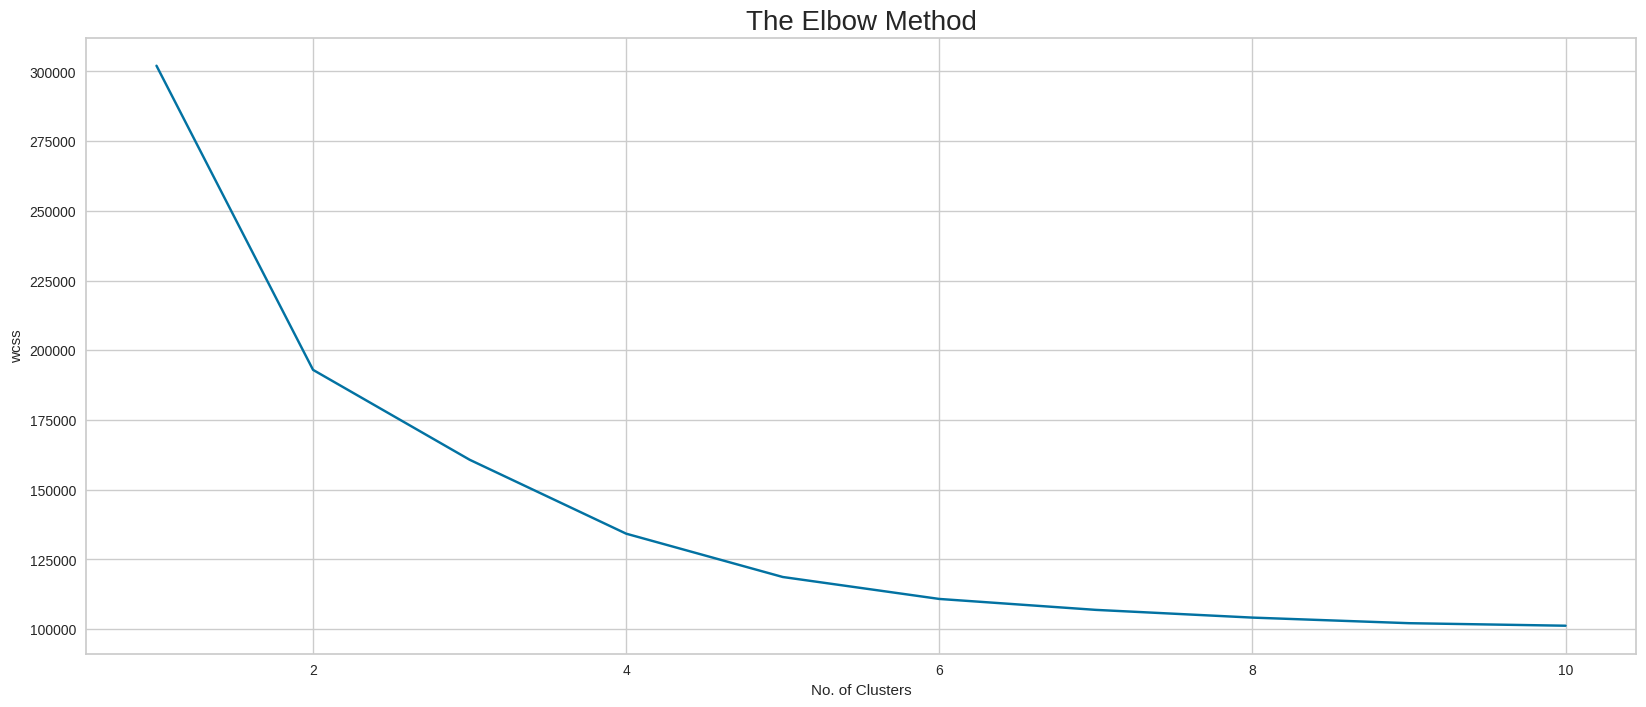

In [4]:
#kmeans
wcss=[]
for k in range(1,11):
    kmeans=KMeans(n_clusters=k)
    cluster=kmeans.fit(embedded_domain_names)
    wcss.append(cluster.inertia_)
plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

In [5]:
#kmeans con il k scelto
k=2 #da cambiare
kmeans=KMeans(n_clusters=k)
cluster=kmeans.fit(embedded_domain_names)
pred_labels=cluster.labels_
silhouette = silhouette_score(embedded_domain_names, true_labels, metric="euclidean")
homogeneity, completeness, v_measure= homogeneity_completeness_v_measure(true_labels, pred_labels)

print("Stats KMeans:")
print(f"Silhouette: {silhouette}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")

/home/lorenzo/PycharmProjects/datascienceETL/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Stats KMeans:
Silhouette: 0.19721487164497375
Homogeneity: 0.2150911590556142
Completeness: 0.9857438433011417
V-measure: 0.3531289234098922


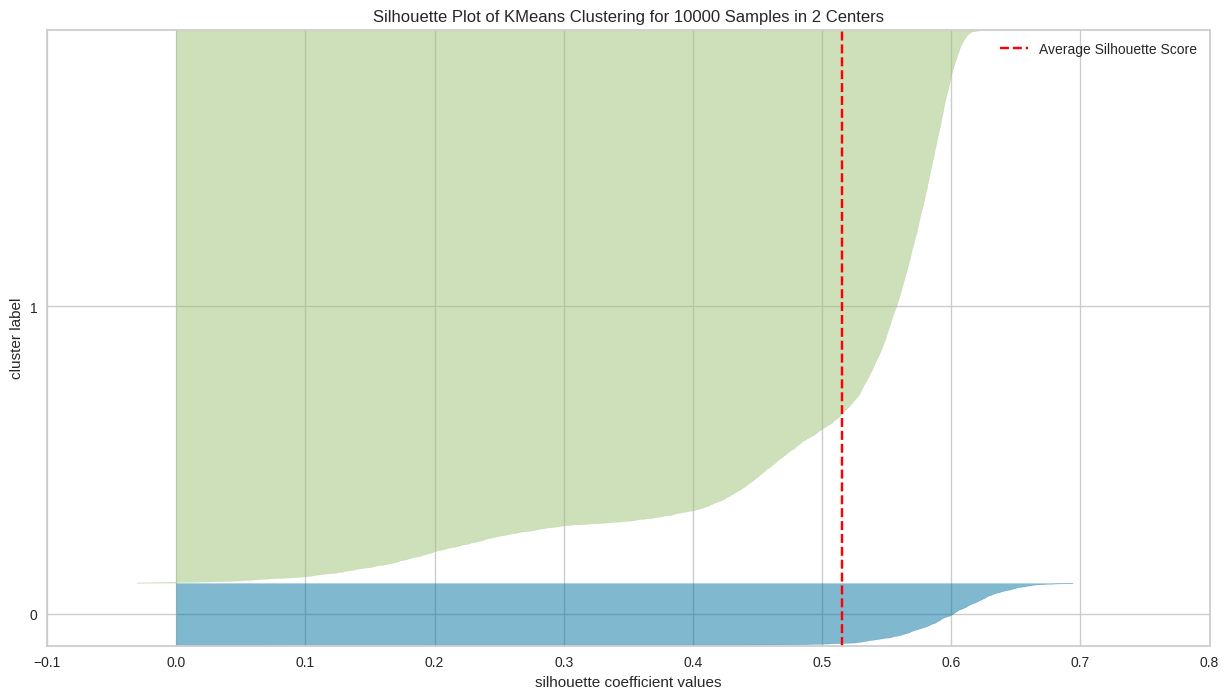

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
# visualizzare la silhouette del kmeans
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
plt.figure(figsize=(15,8))
embedded_domain_names_df = pd.DataFrame(np.array(embedded_domain_names), dtype=float)
visualizer.fit(embedded_domain_names_df)        # Fit the data to the visualizer
visualizer.show() 

In [15]:
cts = []
for min_samples in range(106,213,53):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(embedded_domain_names)
    distances, indices = neighbors_fit.kneighbors(embedded_domain_names)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
    eps=kneedle.knee_y
    print(eps)
    dbscan=DBSCAN(eps=eps, min_samples=min_samples)
    cluster=dbscan.fit(embedded_domain_names)
    pred_labels=cluster.labels_
    print(pred_labels)
    print(set(pred_labels))
    n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
    n_noise = list(pred_labels).count(-1)
    silhouette = silhouette_score(embedded_domain_names, pred_labels, metric="euclidean")
    homogeneity, completeness, v_measure= homogeneity_completeness_v_measure(true_labels, pred_labels)
    print(f"Stats DBScan. min_samples={min_samples}, eps={eps}:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Silhouette: {silhouette}")
    print(f"Homogeneity: {homogeneity}")
    print(f"Completeness: {completeness}")
    print(f"V-measure: {v_measure}")
    print("")#vado a capo
    df = pd.DataFrame({'Labels': true_labels, 'Clusters': pred_labels})
    ct = pd.crosstab(df['Labels'], df['Clusters'])
    ct_labelled = ct.set_index(pd.Index([family for family, i in family_dict.items()])).rename(
        columns={i: f"cluster_{i}" if i != -1 else "cluster_noise" for i in ct.columns})
    cts.append(ct_labelled)

6.280039808305078
[ 0  0  0 ... -1 -1 -1]
{0, 1, -1}
Stats DBScan. min_samples=106, eps=6.280039808305078:
Number of clusters: 2
Number of noise points: 545
Silhouette: 0.3850782513618469
Homogeneity: 0.307669903486698
Completeness: 0.868333966944739
V-measure: 0.45435263356080147

6.280039808305078
[ 0  0  0 ... -1 -1 -1]
{0, 1, -1}
Stats DBScan. min_samples=159, eps=6.280039808305078:
Number of clusters: 2
Number of noise points: 733
Silhouette: 0.3928454518318176
Homogeneity: 0.3472006654461738
Completeness: 0.8979903308368745
V-measure: 0.5007791437000083

6.280039808305078
[ 0  0  0 ... -1 -1 -1]
{0, 1, -1}
Stats DBScan. min_samples=212, eps=6.280039808305078:
Number of clusters: 2
Number of noise points: 852
Silhouette: 0.39977535605430603
Homogeneity: 0.37648068812538643
Completeness: 0.9290755429794108
V-measure: 0.5358313819165998



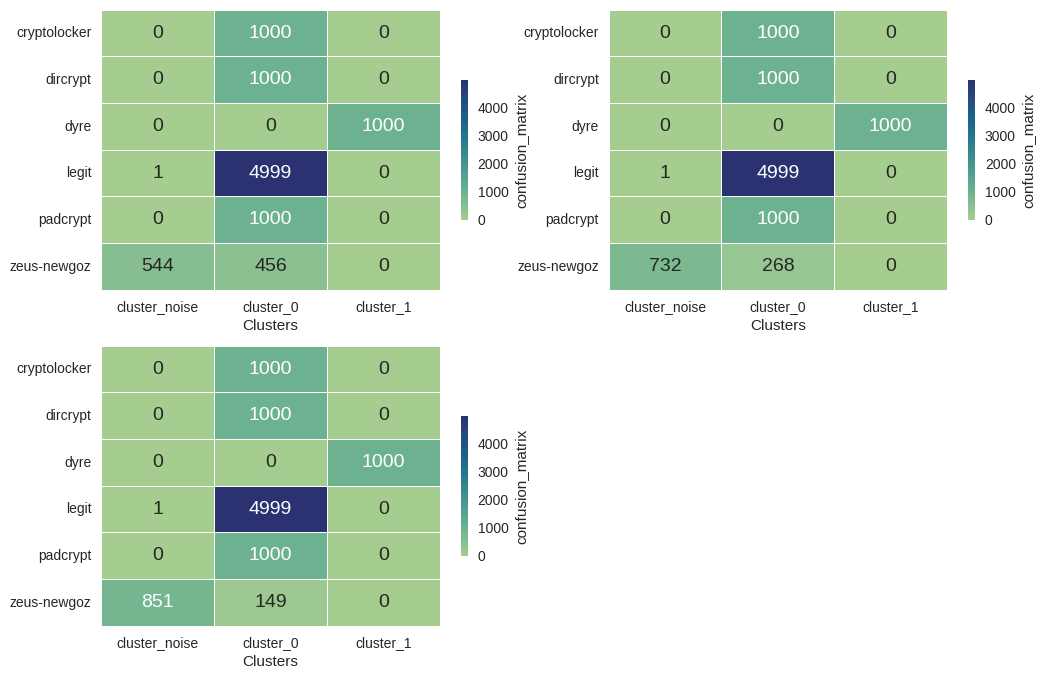

In [23]:
# print confusion matrices for clustering
plt.figure(figsize=(12,8))
for i in range(len(cts)):
    plt.subplot(2,2, i+1)
    sns.heatmap(cts[i], annot=True, linewidths=.5, fmt="d", cmap='crest', annot_kws={"size": 14},
                cbar_kws={"shrink": 0.5, "label": f"confusion_matrix"}, xticklabels=True, yticklabels=True)

In [24]:
# visualizzare la silhouette del kmeans
visualizer = SilhouetteVisualizer(dbscan, colors='yellowbrick')
plt.figure(figsize=(15,8))
embedded_domain_names_df = pd.DataFrame(np.array(embedded_domain_names), dtype=float)
visualizer.fit(embedded_domain_names_df)        # Fit the data to the visualizer
visualizer.show() 

AttributeError: 'DBSCAN' object has no attribute 'n_clusters'

<Figure size 1500x800 with 0 Axes>